In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset,TensorDataset
from sklearn.model_selection import KFold
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
from learning_tool import *
import sys
sys.path.append('..')

from model.model import *

2023-07-19 17:47:50.943338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 17:47:51.579194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm.notebook import tqdm
from IPython.display import display
from sklearn.model_selection import train_test_split

In [3]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [4]:
# デバイスの割り当て

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device('cpu')

cuda:0


In [5]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
# 乱数初期化
torch_seed()

In [6]:
df = pd.read_csv('../resource/txt_vec_and_label_camel_19.csv', index_col=0)
df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,contains_bug
commit_hash,,,,,,,,,,,,,,,,,,,,,
77b260b65ba821b3443d922320cc3d9b708c8d83,6,6,50,72,30,43,14,9,13,6,...,14,98,9,1,13,1,6,1,37,1
a4701ac4bf5b50810914796e284b0e3f78a240bc,6,50,72,30,43,14,9,13,6,149,...,2,78,88,2,415,8,704,3,3,1
0a0bad2c4a35be88f7732def261a03737fab662e,6,50,72,30,43,14,9,13,6,727,...,8,44,34,21,33,33,33,225,10,1
4de90eba5a4628f573c5e0536ed9160b6f1ea29d,608,30,43,14,9,13,6,138,61,138,...,0,0,0,0,0,0,0,0,0,0
4292f69f0afd36a7335515cc565ea41521bfa5cd,6,50,72,30,43,14,9,13,6,37,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
da0d0426ebf80387c4eb5f169bed5df813dd22da,6,50,72,30,43,14,9,13,6,22,...,0,0,0,0,0,0,0,0,0,0
f3f792e763685511088a10afb2d58a75ac131421,6,50,72,30,43,14,9,13,6,6,...,11,9,1,13,1,6,1,44,4,1
f59887aeaf409d5282548a5d559f5ce58c43c601,6,50,72,30,43,14,9,13,6,136,...,0,0,0,0,0,0,0,0,0,1


In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df, features, labels):
        self.features_values = df[features].values
        self.labels = df[labels].values
        
    # len()を使用すると呼ばれる
    def __len__(self):
        return len(self.features_values)

    # 要素を参照すると呼ばれる関数    
    def __getitem__(self, idx):
        features_x = torch.LongTensor(self.features_values[idx])
        labels = torch.as_tensor(self.labels[idx])
        return features_x, labels

In [8]:
columns = df.columns.values
features_columns = columns[:-1]
labels_column = columns[-1]
print(features_columns)
print(labels_column)
dataset = MyDataset(df, features_columns, labels_column)

['0' '1' '2' ... '1997' '1998' '1999']
contains_bug


In [9]:
df['contains_bug'].value_counts() / df.shape[0]

contains_bug
0    0.630281
1    0.369719
Name: count, dtype: float64

In [10]:
len(dataset[0][0])

2000

In [11]:
n_output = 2
n_hidden = 100
print(f'n_hidden: {n_hidden} n_output: {n_output}')

n_hidden: 100 n_output: 2


In [12]:
def undersampling(dataset):
    target = np.zeros(0)
    target = (np.hstack(data[1].numpy() for data in dataset))
    print (
        'original target  0/1: {}/{}'.format(
        len(np.where(target == 0)[0]), len(np.where(target == 1)[0]))
    )
    
    class_indices = [np.where(target == t)[0] for t in np.unique(target)]
    class_sample_count = np.array([len(idx) for idx in class_indices])
    min_class_idx = np.argmin(class_sample_count)
    max_class_idx = np.argmax(class_sample_count)
    undersample_indices = np.random.choice(class_indices[max_class_idx], size=int(min(class_sample_count)), replace=False)
    combined_indices = np.hstack([class_indices[min_class_idx], undersample_indices])
    
    features = dataset[combined_indices][0]
    labels = dataset[combined_indices][1]
    
    shuffle_indices = torch.randperm(len(features))
    features = features[shuffle_indices]
    labels = labels[shuffle_indices]
    
    undersampled_dataset = torch.utils.data.TensorDataset(features, labels)
    
    target = np.zeros(0)
    target = (np.hstack(data[1].numpy() for data in undersampled_dataset))
    print (
        'undersampled target  0/1: {}/{}'.format(
        len(np.where(target == 0)[0]), len(np.where(target == 1)[0]))
    )
    return undersampled_dataset
undersampling(dataset)

original target  0/1: 16335/9582
undersampled target  0/1: 9582/9582


In [13]:
# dataset2 = undersampling(dataset)
# dataset2[0]

In [14]:
# for data in dataset2:
#    print(data[1])

In [16]:
# 学習率
lr = 0.001

# 繰り返し回数
num_epochs = 20

# 評価結果記録用
cv_history = np.zeros((0,6))
each_history = np.zeros((0,num_epochs,6))
log_dir = "../logs/"
writer = SummaryWriter(log_dir)

batch_size = 80
num_splits = 10
kf = KFold(n_splits=num_splits)
cv_cnt = 0

undersampled_dataset = undersampling(dataset)

for train_index, test_index in kf.split(undersampled_dataset):
    cv_cnt += 1
    history = np.zeros((0,6))
    train_dataset = Subset(undersampled_dataset, train_index)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=8)
    test_dataset   = Subset(undersampled_dataset, test_index)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=8)
    
    # モデルインスタンス生成
    net = CNN(n_output, n_hidden).to(device)
    # net._initialize_weights()
    # 最適化関数: 勾配降下法
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)
    # optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 損失関数： 交差エントロピー関数
    criterion = nn.CrossEntropyLoss()
    
    #学習
    history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history, writer)
    
    #1交差ごとの記録
    each_history = np.vstack((each_history, [history]))
    cv_avg_train_loss = np.average(history[:,1])
    cv_train_acc = np.average(history[:,2])
    cv_avg_val_loss = np.average(history[:,3])
    cv_val_acc = np.average(history[:,4])
    cv_avg_auc = np.average(history[:,5])
    item = np.array([cv_cnt, cv_avg_train_loss, cv_train_acc, cv_avg_val_loss, cv_val_acc, cv_avg_auc])
    cv_history = np.vstack((cv_history, item))
    print(f'CV [{cv_cnt}/{num_splits}], loss: {cv_avg_train_loss:.5f} acc: {cv_train_acc:.5f} val_loss: {cv_avg_val_loss:.5f}, val_acc: {cv_val_acc:.5f}, auc_score: {cv_avg_auc:.5f}')

original target  0/1: 16335/9582
undersampled target  0/1: 9582/9582


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.65371 acc: 0.67791 val_loss: 0.55650, val_acc: 0.70423, auc_score:0.77584


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.55592 acc: 0.71560 val_loss: 0.55123, val_acc: 0.71727, auc_score:0.77980


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.54001 acc: 0.72789 val_loss: 0.56317, val_acc: 0.70788, auc_score:0.78306


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.53058 acc: 0.73265 val_loss: 0.55057, val_acc: 0.71466, auc_score:0.78321


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.52244 acc: 0.73532 val_loss: 0.54026, val_acc: 0.72040, auc_score:0.78889


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.50206 acc: 0.75068 val_loss: 0.54146, val_acc: 0.72457, auc_score:0.79099


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.50329 acc: 0.75404 val_loss: 0.53750, val_acc: 0.72979, auc_score:0.79504


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.49377 acc: 0.76152 val_loss: 0.56145, val_acc: 0.70214, auc_score:0.79730


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.48614 acc: 0.76680 val_loss: 0.54208, val_acc: 0.72822, auc_score:0.79855


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.48610 acc: 0.76332 val_loss: 0.55024, val_acc: 0.72144, auc_score:0.79999


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.46552 acc: 0.77712 val_loss: 0.55079, val_acc: 0.71831, auc_score:0.79021


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.46119 acc: 0.77956 val_loss: 0.54047, val_acc: 0.72405, auc_score:0.79783


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.44676 acc: 0.78576 val_loss: 0.54532, val_acc: 0.73031, auc_score:0.79922


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.43301 acc: 0.80031 val_loss: 0.54170, val_acc: 0.72040, auc_score:0.80078


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.41831 acc: 0.80629 val_loss: 0.55126, val_acc: 0.73083, auc_score:0.79757


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.40239 acc: 0.81713 val_loss: 0.55670, val_acc: 0.72666, auc_score:0.79807


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.36141 acc: 0.84403 val_loss: 0.57345, val_acc: 0.72561, auc_score:0.79332


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.35072 acc: 0.84739 val_loss: 0.57962, val_acc: 0.71309, auc_score:0.78116


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.33133 acc: 0.85893 val_loss: 0.58367, val_acc: 0.72248, auc_score:0.79619


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.31192 acc: 0.86931 val_loss: 0.59639, val_acc: 0.71622, auc_score:0.78988
CV [1/10], loss: 0.46283 acc: 0.77858 val_loss: 0.55569, val_acc: 0.71993, auc_score: 0.79184


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.65820 acc: 0.67252 val_loss: 0.56990, val_acc: 0.70631, auc_score:0.76445


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.55205 acc: 0.71937 val_loss: 0.58161, val_acc: 0.69118, auc_score:0.75979


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.53657 acc: 0.72865 val_loss: 0.57647, val_acc: 0.69066, auc_score:0.76538


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.51431 acc: 0.74546 val_loss: 0.56226, val_acc: 0.70423, auc_score:0.77005


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.50713 acc: 0.74767 val_loss: 0.59235, val_acc: 0.70892, auc_score:0.77163


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.49425 acc: 0.75770 val_loss: 0.63506, val_acc: 0.65676, auc_score:0.76324


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.49671 acc: 0.75532 val_loss: 0.56433, val_acc: 0.70944, auc_score:0.77405


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.46517 acc: 0.77463 val_loss: 0.58610, val_acc: 0.69275, auc_score:0.77100


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.45130 acc: 0.78588 val_loss: 0.57486, val_acc: 0.70996, auc_score:0.77275


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.44479 acc: 0.78622 val_loss: 0.58326, val_acc: 0.70162, auc_score:0.75960


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.43702 acc: 0.79631 val_loss: 0.58401, val_acc: 0.70057, auc_score:0.76671


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.40897 acc: 0.81516 val_loss: 0.64955, val_acc: 0.67658, auc_score:0.75948


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.38769 acc: 0.82432 val_loss: 0.61174, val_acc: 0.70110, auc_score:0.76660


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.37221 acc: 0.83423 val_loss: 0.61729, val_acc: 0.70944, auc_score:0.76888


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.36066 acc: 0.83928 val_loss: 0.63807, val_acc: 0.67919, auc_score:0.76043


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.33621 acc: 0.85580 val_loss: 0.63533, val_acc: 0.68962, auc_score:0.75545


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.30396 acc: 0.87441 val_loss: 0.65260, val_acc: 0.69640, auc_score:0.75468


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.27200 acc: 0.89343 val_loss: 0.67513, val_acc: 0.69223, auc_score:0.75408


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.28444 acc: 0.88247 val_loss: 0.67790, val_acc: 0.69953, auc_score:0.76101


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.23643 acc: 0.91111 val_loss: 0.68661, val_acc: 0.70162, auc_score:0.75372
CV [2/10], loss: 0.42600 acc: 0.80000 val_loss: 0.61272, val_acc: 0.69591, auc_score: 0.76365


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.65500 acc: 0.67803 val_loss: 0.57561, val_acc: 0.69379, auc_score:0.75931


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.56224 acc: 0.71114 val_loss: 0.57429, val_acc: 0.69066, auc_score:0.76154


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.53872 acc: 0.72795 val_loss: 0.57173, val_acc: 0.70579, auc_score:0.76837


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.54010 acc: 0.72360 val_loss: 0.59077, val_acc: 0.68284, auc_score:0.77341


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.52134 acc: 0.73711 val_loss: 0.57046, val_acc: 0.69797, auc_score:0.77028


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.52255 acc: 0.73798 val_loss: 0.56702, val_acc: 0.70318, auc_score:0.77416


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.51508 acc: 0.74285 val_loss: 0.58018, val_acc: 0.69901, auc_score:0.77344


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.51075 acc: 0.74581 val_loss: 0.57656, val_acc: 0.69744, auc_score:0.77083


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.50174 acc: 0.74743 val_loss: 0.56818, val_acc: 0.70683, auc_score:0.77469


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.49738 acc: 0.75770 val_loss: 0.56859, val_acc: 0.70318, auc_score:0.77454


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.49033 acc: 0.75944 val_loss: 0.58421, val_acc: 0.69797, auc_score:0.77680


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.47871 acc: 0.76738 val_loss: 0.62396, val_acc: 0.66354, auc_score:0.77339


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.48268 acc: 0.76494 val_loss: 0.56878, val_acc: 0.70475, auc_score:0.77667


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.45858 acc: 0.78298 val_loss: 0.58235, val_acc: 0.69744, auc_score:0.77663


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.44226 acc: 0.79365 val_loss: 0.61410, val_acc: 0.69066, auc_score:0.77667


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.42815 acc: 0.80501 val_loss: 0.58439, val_acc: 0.69953, auc_score:0.77293


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.40398 acc: 0.81550 val_loss: 0.62460, val_acc: 0.70057, auc_score:0.77822


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.38012 acc: 0.83342 val_loss: 0.62179, val_acc: 0.69640, auc_score:0.77029


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.37617 acc: 0.83238 val_loss: 0.59439, val_acc: 0.70631, auc_score:0.76954


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.36388 acc: 0.83667 val_loss: 0.61439, val_acc: 0.70057, auc_score:0.76831
CV [3/10], loss: 0.48349 acc: 0.76505 val_loss: 0.58782, val_acc: 0.69692, auc_score: 0.77200


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.67065 acc: 0.67270 val_loss: 0.56035, val_acc: 0.71049, auc_score:0.77721


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.55153 acc: 0.72123 val_loss: 0.55883, val_acc: 0.71101, auc_score:0.77022


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.54640 acc: 0.72128 val_loss: 0.55913, val_acc: 0.70423, auc_score:0.77930


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.52649 acc: 0.73479 val_loss: 0.57552, val_acc: 0.69588, auc_score:0.77749


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.51183 acc: 0.74222 val_loss: 0.55734, val_acc: 0.71049, auc_score:0.78316


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.51484 acc: 0.74483 val_loss: 0.58053, val_acc: 0.68597, auc_score:0.78170


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.50166 acc: 0.75457 val_loss: 0.56765, val_acc: 0.71309, auc_score:0.78060


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.49245 acc: 0.75775 val_loss: 0.56358, val_acc: 0.71674, auc_score:0.78112


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.47699 acc: 0.77237 val_loss: 0.56917, val_acc: 0.71101, auc_score:0.78131


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.46345 acc: 0.77985 val_loss: 0.56255, val_acc: 0.71831, auc_score:0.78005


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.45223 acc: 0.78483 val_loss: 0.57544, val_acc: 0.70788, auc_score:0.78102


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.43396 acc: 0.79602 val_loss: 0.57290, val_acc: 0.70370, auc_score:0.77196


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.43005 acc: 0.79892 val_loss: 0.58374, val_acc: 0.70370, auc_score:0.76169


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.42697 acc: 0.79921 val_loss: 0.60175, val_acc: 0.69901, auc_score:0.78019


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.39880 acc: 0.81678 val_loss: 0.58982, val_acc: 0.71414, auc_score:0.78052


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.37373 acc: 0.83377 val_loss: 0.59099, val_acc: 0.71570, auc_score:0.78090


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.36583 acc: 0.83928 val_loss: 0.60698, val_acc: 0.71257, auc_score:0.77912


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.32337 acc: 0.86548 val_loss: 0.60469, val_acc: 0.70631, auc_score:0.77482


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.30528 acc: 0.87175 val_loss: 0.63289, val_acc: 0.71570, auc_score:0.77215


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.27445 acc: 0.89059 val_loss: 0.65006, val_acc: 0.70579, auc_score:0.76746
CV [4/10], loss: 0.45205 acc: 0.78491 val_loss: 0.58320, val_acc: 0.70809, auc_score: 0.77710


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.66809 acc: 0.67851 val_loss: 0.58014, val_acc: 0.69676, auc_score:0.75709


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.55954 acc: 0.71278 val_loss: 0.57477, val_acc: 0.69937, auc_score:0.76063


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.55483 acc: 0.71452 val_loss: 0.57447, val_acc: 0.70042, auc_score:0.76574


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.53076 acc: 0.73000 val_loss: 0.57031, val_acc: 0.70355, auc_score:0.77209


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.52830 acc: 0.73626 val_loss: 0.57647, val_acc: 0.70668, auc_score:0.77030


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.51889 acc: 0.73922 val_loss: 0.57096, val_acc: 0.70198, auc_score:0.76937


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.51268 acc: 0.74304 val_loss: 0.56770, val_acc: 0.70511, auc_score:0.76818


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.52932 acc: 0.72942 val_loss: 0.56560, val_acc: 0.71764, auc_score:0.77430


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.51714 acc: 0.73991 val_loss: 0.57017, val_acc: 0.70668, auc_score:0.77373


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.49886 acc: 0.75215 val_loss: 0.56719, val_acc: 0.70146, auc_score:0.77149


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.48911 acc: 0.75864 val_loss: 0.57495, val_acc: 0.70616, auc_score:0.77049


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.48000 acc: 0.76722 val_loss: 0.57217, val_acc: 0.70720, auc_score:0.76991


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.47512 acc: 0.76983 val_loss: 0.60493, val_acc: 0.68633, auc_score:0.76787


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.47207 acc: 0.76989 val_loss: 0.56994, val_acc: 0.70303, auc_score:0.77261


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.44981 acc: 0.78966 val_loss: 0.57597, val_acc: 0.70198, auc_score:0.76823


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.44204 acc: 0.79058 val_loss: 0.58396, val_acc: 0.70198, auc_score:0.77137


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.41691 acc: 0.80728 val_loss: 0.59960, val_acc: 0.69154, auc_score:0.76623


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.40917 acc: 0.81285 val_loss: 0.59961, val_acc: 0.70407, auc_score:0.77112


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.39539 acc: 0.82050 val_loss: 0.60423, val_acc: 0.69990, auc_score:0.76736


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.36298 acc: 0.84027 val_loss: 0.60716, val_acc: 0.69990, auc_score:0.76393
CV [5/10], loss: 0.49055 acc: 0.76013 val_loss: 0.58052, val_acc: 0.70209, auc_score: 0.76860


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.66817 acc: 0.66593 val_loss: 0.56768, val_acc: 0.71399, auc_score:0.77830


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.54921 acc: 0.71655 val_loss: 0.58433, val_acc: 0.70303, auc_score:0.78219


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.54736 acc: 0.72084 val_loss: 0.55960, val_acc: 0.71712, auc_score:0.78882


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.52707 acc: 0.73417 val_loss: 0.55291, val_acc: 0.70981, auc_score:0.78820


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.51904 acc: 0.73823 val_loss: 0.55372, val_acc: 0.71294, auc_score:0.78394


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.51576 acc: 0.73864 val_loss: 0.55617, val_acc: 0.71503, auc_score:0.78534


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.48858 acc: 0.76299 val_loss: 0.56479, val_acc: 0.71033, auc_score:0.78079


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.49501 acc: 0.75974 val_loss: 0.55386, val_acc: 0.70929, auc_score:0.78458


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.48150 acc: 0.76606 val_loss: 0.55920, val_acc: 0.71138, auc_score:0.78041


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.47197 acc: 0.77423 val_loss: 0.57372, val_acc: 0.71451, auc_score:0.77978


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.46168 acc: 0.77824 val_loss: 0.55831, val_acc: 0.70668, auc_score:0.78219


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.43913 acc: 0.79679 val_loss: 0.57740, val_acc: 0.72025, auc_score:0.78241


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.42405 acc: 0.80351 val_loss: 0.57926, val_acc: 0.70825, auc_score:0.77929


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.40309 acc: 0.82137 val_loss: 0.59684, val_acc: 0.70146, auc_score:0.77038


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.40396 acc: 0.81163 val_loss: 0.60768, val_acc: 0.69781, auc_score:0.77473


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.38807 acc: 0.82583 val_loss: 0.59212, val_acc: 0.70668, auc_score:0.77211


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.33711 acc: 0.86080 val_loss: 0.61398, val_acc: 0.70094, auc_score:0.76535


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.30250 acc: 0.87784 val_loss: 0.63733, val_acc: 0.69207, auc_score:0.76696


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.30009 acc: 0.87604 val_loss: 0.63483, val_acc: 0.69937, auc_score:0.77000


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.27420 acc: 0.89292 val_loss: 0.66095, val_acc: 0.68424, auc_score:0.75180
CV [6/10], loss: 0.44988 acc: 0.78612 val_loss: 0.58423, val_acc: 0.70676, auc_score: 0.77738


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.67762 acc: 0.67457 val_loss: 0.57760, val_acc: 0.69729, auc_score:0.77898


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.56431 acc: 0.70623 val_loss: 0.54277, val_acc: 0.71712, auc_score:0.79090


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.54153 acc: 0.72223 val_loss: 0.56885, val_acc: 0.70094, auc_score:0.78200


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.52837 acc: 0.73232 val_loss: 0.54088, val_acc: 0.71086, auc_score:0.78869


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.52344 acc: 0.73597 val_loss: 0.54438, val_acc: 0.71347, auc_score:0.79327


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.50833 acc: 0.74954 val_loss: 0.54841, val_acc: 0.70825, auc_score:0.80125


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.49864 acc: 0.75551 val_loss: 0.54184, val_acc: 0.71503, auc_score:0.79167


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.49466 acc: 0.75626 val_loss: 0.53777, val_acc: 0.72495, auc_score:0.79867


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.47870 acc: 0.77058 val_loss: 0.53902, val_acc: 0.72860, auc_score:0.79937


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.47530 acc: 0.77047 val_loss: 0.53808, val_acc: 0.72025, auc_score:0.80257


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.46277 acc: 0.78096 val_loss: 0.53890, val_acc: 0.72912, auc_score:0.80098


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.44126 acc: 0.79621 val_loss: 0.54880, val_acc: 0.71973, auc_score:0.79499


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.40571 acc: 0.81952 val_loss: 0.55326, val_acc: 0.71608, auc_score:0.78623


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.41427 acc: 0.80850 val_loss: 0.55622, val_acc: 0.72651, auc_score:0.79325


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.36935 acc: 0.83987 val_loss: 0.57470, val_acc: 0.71294, auc_score:0.78987


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.35070 acc: 0.84497 val_loss: 0.56936, val_acc: 0.71921, auc_score:0.79043


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.33425 acc: 0.85882 val_loss: 0.56427, val_acc: 0.71347, auc_score:0.78910


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.30819 acc: 0.87117 val_loss: 0.59932, val_acc: 0.70511, auc_score:0.78406


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.29171 acc: 0.88155 val_loss: 0.63272, val_acc: 0.70303, auc_score:0.78064


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.26715 acc: 0.89906 val_loss: 0.62693, val_acc: 0.70459, auc_score:0.77764
CV [7/10], loss: 0.44681 acc: 0.78871 val_loss: 0.56220, val_acc: 0.71433, auc_score: 0.79073


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.65184 acc: 0.67463 val_loss: 0.58147, val_acc: 0.70303, auc_score:0.76896


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.55797 acc: 0.71260 val_loss: 0.56116, val_acc: 0.71399, auc_score:0.77918


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.53789 acc: 0.72698 val_loss: 0.56494, val_acc: 0.71294, auc_score:0.77921


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.53387 acc: 0.72704 val_loss: 0.55974, val_acc: 0.72182, auc_score:0.78152


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.52630 acc: 0.73469 val_loss: 0.55566, val_acc: 0.72495, auc_score:0.78366


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.50781 acc: 0.74536 val_loss: 0.55613, val_acc: 0.71764, auc_score:0.78859


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.49994 acc: 0.75441 val_loss: 0.55697, val_acc: 0.72129, auc_score:0.78610


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.49261 acc: 0.76090 val_loss: 0.57066, val_acc: 0.71555, auc_score:0.78401


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.48710 acc: 0.76003 val_loss: 0.58096, val_acc: 0.69937, auc_score:0.78563


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.48147 acc: 0.76797 val_loss: 0.57494, val_acc: 0.73069, auc_score:0.78901


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.46915 acc: 0.77319 val_loss: 0.55470, val_acc: 0.72495, auc_score:0.78910


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.44750 acc: 0.78705 val_loss: 0.57088, val_acc: 0.71712, auc_score:0.78337


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.43608 acc: 0.79534 val_loss: 0.56948, val_acc: 0.72077, auc_score:0.78004


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.41279 acc: 0.81325 val_loss: 0.57571, val_acc: 0.70720, auc_score:0.78285


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.39286 acc: 0.82340 val_loss: 0.58275, val_acc: 0.71608, auc_score:0.77971


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.39952 acc: 0.81696 val_loss: 0.59176, val_acc: 0.71033, auc_score:0.77940


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.35281 acc: 0.85158 val_loss: 0.61441, val_acc: 0.70198, auc_score:0.77461


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.33490 acc: 0.85801 val_loss: 0.61236, val_acc: 0.69520, auc_score:0.76631


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.30013 acc: 0.87854 val_loss: 0.63622, val_acc: 0.69885, auc_score:0.77060


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.27760 acc: 0.89228 val_loss: 0.65411, val_acc: 0.69885, auc_score:0.76814
CV [8/10], loss: 0.45501 acc: 0.78271 val_loss: 0.58125, val_acc: 0.71263, auc_score: 0.78000


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.65801 acc: 0.67921 val_loss: 0.56966, val_acc: 0.71294, auc_score:0.77417


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.55587 acc: 0.71487 val_loss: 0.56196, val_acc: 0.71086, auc_score:0.77872


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.54430 acc: 0.72420 val_loss: 0.55579, val_acc: 0.72599, auc_score:0.78574


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.52857 acc: 0.73440 val_loss: 0.55541, val_acc: 0.71608, auc_score:0.78990


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.51964 acc: 0.74154 val_loss: 0.54822, val_acc: 0.72860, auc_score:0.79061


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.51404 acc: 0.74125 val_loss: 0.55650, val_acc: 0.71555, auc_score:0.78775


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.50236 acc: 0.75104 val_loss: 0.57553, val_acc: 0.70251, auc_score:0.79262


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.49723 acc: 0.75707 val_loss: 0.54906, val_acc: 0.72756, auc_score:0.79230


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.47843 acc: 0.76687 val_loss: 0.55503, val_acc: 0.71816, auc_score:0.78936


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.49052 acc: 0.76003 val_loss: 0.56592, val_acc: 0.71608, auc_score:0.78878


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.47195 acc: 0.77377 val_loss: 0.56254, val_acc: 0.71451, auc_score:0.78569


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.45255 acc: 0.78780 val_loss: 0.56419, val_acc: 0.71086, auc_score:0.78846


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.46897 acc: 0.77244 val_loss: 0.55531, val_acc: 0.71712, auc_score:0.79370


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.43835 acc: 0.79806 val_loss: 0.56341, val_acc: 0.71347, auc_score:0.78800


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.40448 acc: 0.81853 val_loss: 0.57050, val_acc: 0.71764, auc_score:0.79004


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.40747 acc: 0.81447 val_loss: 0.56854, val_acc: 0.70511, auc_score:0.78376


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.38323 acc: 0.83175 val_loss: 0.60346, val_acc: 0.69207, auc_score:0.76671


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.38261 acc: 0.82734 val_loss: 0.58240, val_acc: 0.71033, auc_score:0.78532


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.33585 acc: 0.85998 val_loss: 0.59035, val_acc: 0.71451, auc_score:0.78288


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.30549 acc: 0.87790 val_loss: 0.61069, val_acc: 0.71451, auc_score:0.77983
CV [9/10], loss: 0.46700 acc: 0.77663 val_loss: 0.56822, val_acc: 0.71422, auc_score: 0.78572


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.65186 acc: 0.67359 val_loss: 0.58314, val_acc: 0.68267, auc_score:0.76766


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.56595 acc: 0.70588 val_loss: 0.57711, val_acc: 0.70668, auc_score:0.77725


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.52954 acc: 0.73365 val_loss: 0.55824, val_acc: 0.71712, auc_score:0.76238


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.52613 acc: 0.73464 val_loss: 0.56112, val_acc: 0.71138, auc_score:0.77700


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.50177 acc: 0.75238 val_loss: 0.56675, val_acc: 0.70877, auc_score:0.78169


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.51245 acc: 0.74385 val_loss: 0.55738, val_acc: 0.72234, auc_score:0.79290


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.48278 acc: 0.76699 val_loss: 0.55156, val_acc: 0.72756, auc_score:0.78484


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.49519 acc: 0.75203 val_loss: 0.56008, val_acc: 0.71138, auc_score:0.79210


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.47729 acc: 0.77006 val_loss: 0.55448, val_acc: 0.72704, auc_score:0.79006


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.45725 acc: 0.78189 val_loss: 0.54591, val_acc: 0.73017, auc_score:0.79107


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.44465 acc: 0.79180 val_loss: 0.56851, val_acc: 0.72182, auc_score:0.79064


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.42560 acc: 0.80485 val_loss: 0.58592, val_acc: 0.71608, auc_score:0.79103


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.43658 acc: 0.79563 val_loss: 0.55875, val_acc: 0.71868, auc_score:0.78383


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.41199 acc: 0.81093 val_loss: 0.56417, val_acc: 0.73173, auc_score:0.78771


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.37414 acc: 0.83795 val_loss: 0.58740, val_acc: 0.72077, auc_score:0.78318


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.36740 acc: 0.83708 val_loss: 0.59863, val_acc: 0.72182, auc_score:0.77994


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.36771 acc: 0.83836 val_loss: 0.59408, val_acc: 0.71347, auc_score:0.78641


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.32618 acc: 0.86474 val_loss: 0.60948, val_acc: 0.72025, auc_score:0.78751


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.29970 acc: 0.88062 val_loss: 0.63659, val_acc: 0.70668, auc_score:0.77211


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.26519 acc: 0.89697 val_loss: 0.63551, val_acc: 0.70877, auc_score:0.77195
CV [10/10], loss: 0.44597 acc: 0.78869 val_loss: 0.57774, val_acc: 0.71626, auc_score: 0.78256


初期状態: 損失: 0.55569 精度: 0.71993
最終状態: 損失: 0.57774 精度: 0.71626


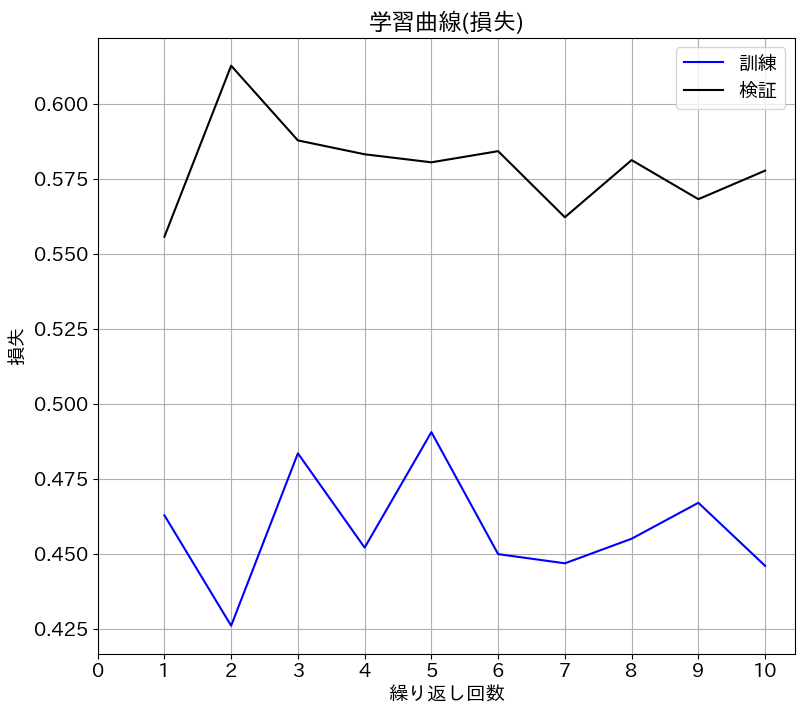

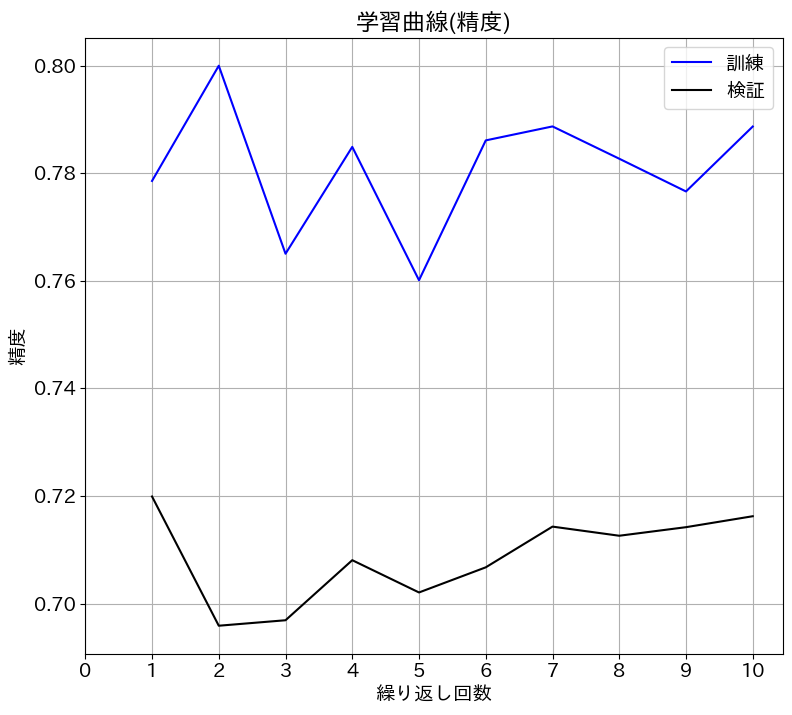

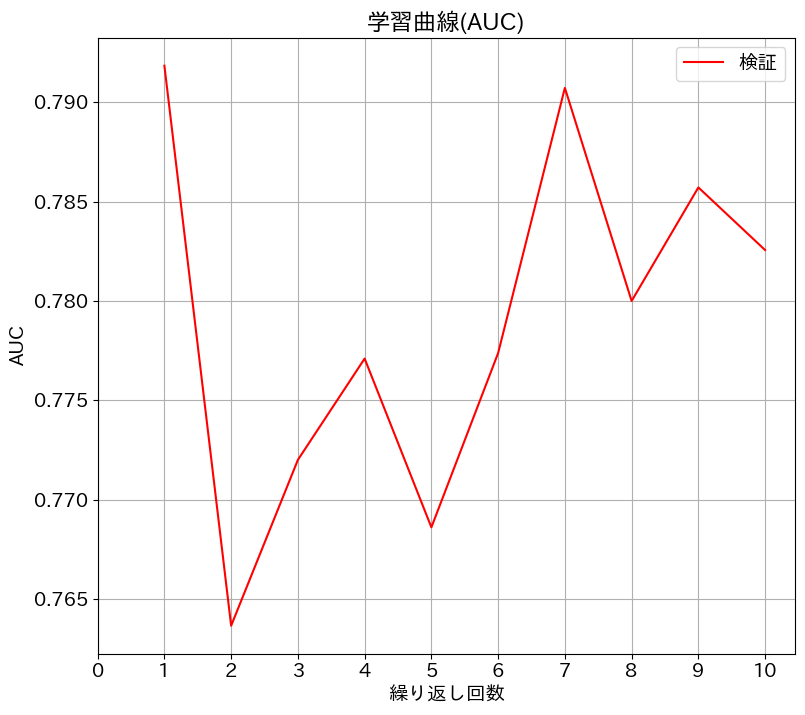

In [17]:
evaluate_history(cv_history)

初期状態: 損失: 0.56035 精度: 0.71049
最終状態: 損失: 0.65006 精度: 0.70579


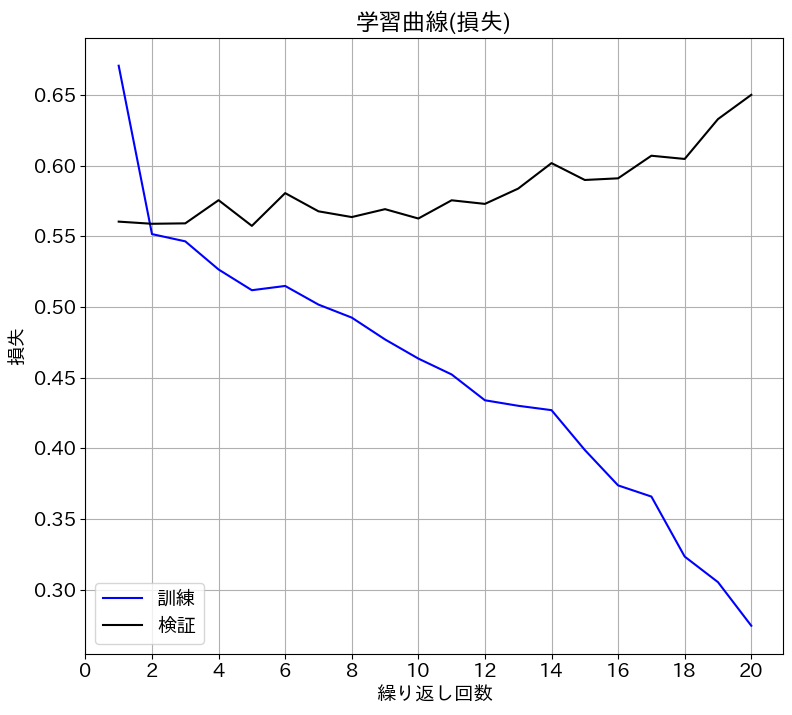

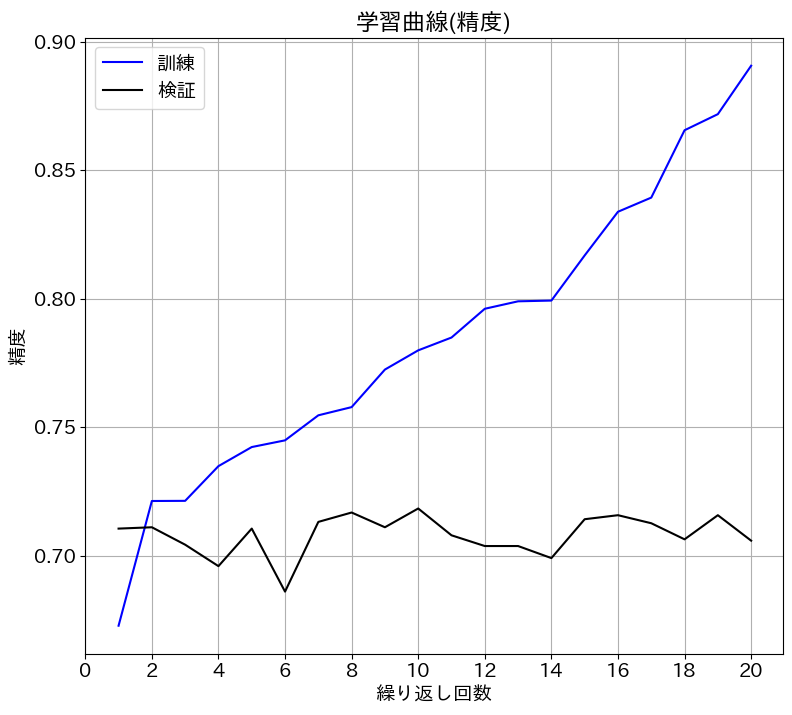

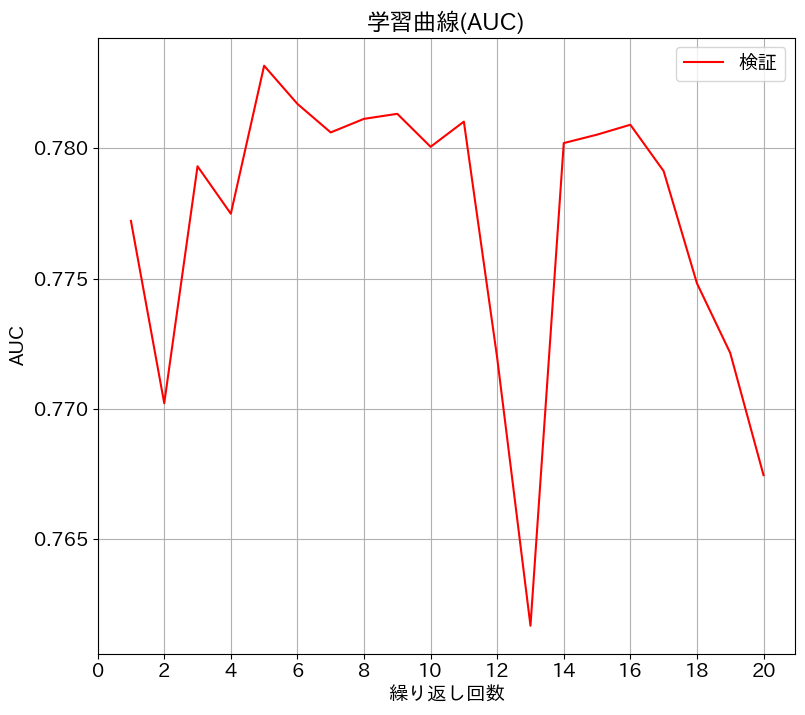

In [24]:
evaluate_history(each_history[3,:,:])

In [19]:
np.save('../result/cv_history', cv_history)
np.save('../result/each_history', each_history)